In [619]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup

In [620]:
bounceTime = 5

In [621]:
# Load games
games = pd.read_csv('data/Premier-League_2023-2024.csv')
games = games[['Year', 'Date', 'Home', 'Away', 'G_home', 'G_away', 'Home_W', 'Draw', 'Away_W']]
games['Date'] = pd.to_datetime(games['Date'])
# Duplicate each game
teams = games['Home'].unique().tolist()
concat_dfs = []
for tm in teams :
    df_home = games[games['Home'] == tm]
    df_home = df_home.rename(columns = {'Home': 'Team', 'Away': 'Opponent', 'G_home': 'G_tm', 'G_away': 'G_opp', 'Home_W': 'Win', 'Away_W': 'Loss'})
    df_home['Home'] = 1
    concat_dfs.append(df_home)
    df_away = games[games['Away'] == tm]
    df_away = df_away.rename(columns = {'Home': 'Opponent', 'Away': 'Team', 'G_home': 'G_opp', 'G_away': 'G_tm', 'Home_W': 'Loss', 'Away_W': 'Win'})
    df_away['Home'] = 0
    concat_dfs.append(df_away)
games = pd.concat(concat_dfs).sort_values('Date')
games['PTS'] = 3 * games['Win'] + games['Draw']
# Rank team's games by date
games['Wk'] = games.groupby(['Year', 'Team'])['Date'].rank()

# Store time range of each season
season_dates = games.groupby('Year')['Date'].min().reset_index().merge(games.groupby('Year')['Date'].max().reset_index(), on = 'Year', suffixes = ['_min', '_max'])

In [622]:
# Scrape table of Premier League managers
url = 'https://en.wikipedia.org/wiki/List_of_Premier_League_managers'
page = requests.get(url)
soup = BeautifulSoup(page.content, 'html')
table = soup.find_all('table')[1]
managers = pd.read_html(str(table))[0][['Name', 'Club', 'From', 'Until', 'Years in League']]
managers['From'] = pd.to_datetime(managers['From'].str.replace(r'\[[a-zA-Z]\]', '', regex = True))

In [623]:
club_map = {'Blackburn Rovers': 'Blackburn',
            'Bolton Wanderers': 'Bolton',
            'Brighton & Hove Albion': 'Brighton',
            'Charlton Athletic': 'Charlton Ath',
            'Huddersfield Town': 'Huddersfield',
            'Manchester United': 'Manchester Utd',
            'Newcastle United': 'Newcastle Utd',
            'Nottingham Forest': "Nott'ham Forest",
            'Queens Park Rangers': 'QPR',
            'Sheffield United': 'Sheffield Utd',
            'Tottenham Hotspur': 'Tottenham',
            'West Bromwich Albion': 'West Brom',
            'West Ham United': 'West Ham',
            'Wolverhampton Wanderers': 'Wolves'}
# Map club name to match FBref names
managers['Club'] = managers['Club'].apply(lambda x: club_map.get(x) if x in club_map.keys() else x)

# Get the date of manager's first game
def get_debut_date(row) :
    games_ = games[games['Team'] == row['Club']]
    following_dates = [date for date in games_['Date'].tolist() if date > row['From']]
    if len(following_dates) > 1 :
        return min(following_dates)
    else :
        return np.nan # NaN if manager started later than 2023-24

# Apply the function to two columns
managers['debut_date'] = managers.apply(get_debut_date, axis = 1)
managers = managers.copy()[managers['debut_date'].notna()]
managers = managers[['Name', 'Club', 'debut_date']]

In [624]:
# Inner merge of games and manager debuts
debuts = games.merge(managers.rename(columns = {'debut_date': 'Date', 'Club': 'Team'}), on = ['Date', 'Team'], how = 'inner')

In [625]:
# Only keep debuts with enough games before and after
debuts = debuts[(debuts['Wk'] > bounceTime) & (debuts['Wk'] <= 38 - bounceTime + 1)]

In [626]:
# Additionally, only keep debuts if where new manager played at least 5 games
dfs = []
for _, df in debuts.groupby(['Year', 'Team']) :
    if len(df) > 1:
        #                  Checks if there is a new debut bouceTime away from a given debut
        df['valid'] = [1 - max([(x - w) < bounceTime and (x - w) > 0 for x in df['Wk']]) for w in df['Wk']]
        dfs.append(df[df['valid'] == 1].drop(columns = ['valid']))
    else :
        dfs.append(df)

debuts = pd.concat(dfs).sort_values(['Year', 'Wk']).reset_index(drop = True)
debuts['duplicated'] = debuts.duplicated(subset = ['Date', 'Team'], keep = False)
debuts['caretaker'] = debuts['Name'].apply(lambda x: '‡' in x)
debuts = debuts[(~debuts['duplicated']) | (~debuts['caretaker'])]
debuts.tail()

,Year,Date,Team,Opponent,G_tm,G_opp,Win,Draw,Loss,Home,PTS,Wk,Name,duplicated,caretaker
153,2023,2023-04-15,Leicester City,Manchester City,1,3,0,0,1,0,0,31.0,Dean Smith,False,False
154,2023,2023-04-27,Tottenham,Manchester Utd,2,2,0,1,0,1,1,33.0,Ryan Mason ‡,False,True
155,2024,2023-12-06,Sheffield Utd,Liverpool,0,2,0,0,1,1,0,15.0,Chris Wilder §,False,False
156,2024,2023-12-23,Nott'ham Forest,Bournemouth,2,3,0,0,1,1,0,18.0,Nuno Espírito Santo †,False,False
158,2024,2024-02-24,Crystal Palace,Burnley,3,0,1,0,0,1,3,26.0,Oliver Glasner †,True,False


In [627]:
ppg_before, ppg_after = [], []
gd_before, gd_after = [], []
for yr, tm, w in zip(debuts['Year'], debuts['Team'], debuts['Wk']) :
    games_sub = games.copy()[(games['Year'] == yr) & (games['Team'] == tm)]
    games_sub = games_sub[(games_sub['Wk'] >= w - bounceTime) & (games_sub['Wk'] < w + bounceTime)].sort_values('Date')

    ppg_before.append(games_sub.head(bounceTime)['PTS'].mean())
    ppg_after.append(games_sub.tail(bounceTime)['PTS'].mean())
    gd_before.append(games_sub.head(bounceTime)['G_tm'].sum() - games_sub.head(bounceTime)['G_opp'].sum())
    gd_after.append(games_sub.tail(bounceTime)['G_tm'].sum() - games_sub.tail(bounceTime)['G_opp'].sum())

In [628]:
debuts['ppg_before'] = ppg_before
debuts['ppg_after'] = ppg_after
debuts['gd_before'] = gd_before
debuts['gd_after'] = gd_after

debuts['ppg_imp'] = (debuts['ppg_after'] - debuts['ppg_before']) / debuts['ppg_before']
debuts['gd_imp'] = debuts['gd_after'] - debuts['gd_before']

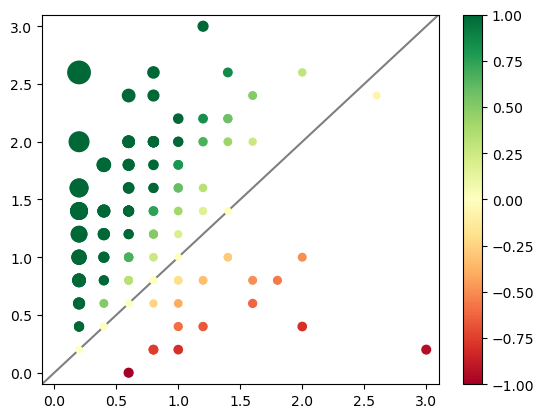

In [629]:
plt.plot([-1, 6], [-1, 6], c = 'k', alpha = 0.5, zorder = 1)
plt.scatter(debuts['ppg_before'], debuts['ppg_after'], c = debuts['ppg_imp'], s = 20 * (debuts['ppg_imp'].abs() + 1), cmap = 'RdYlGn', vmin = -1, vmax = 1)
plt.xlim([-0.1, 3.1])
plt.ylim([-0.1, 3.1])
plt.colorbar()
plt.show()

In [630]:
debuts['duplicated'] = debuts.duplicated(subset = ['Date', 'Team'], keep = False)
debuts['caretaker'] = debuts['Name'].apply(lambda x: '‡' in x)
debuts = debuts[(~debuts['duplicated']) | (~debuts['caretaker'])]

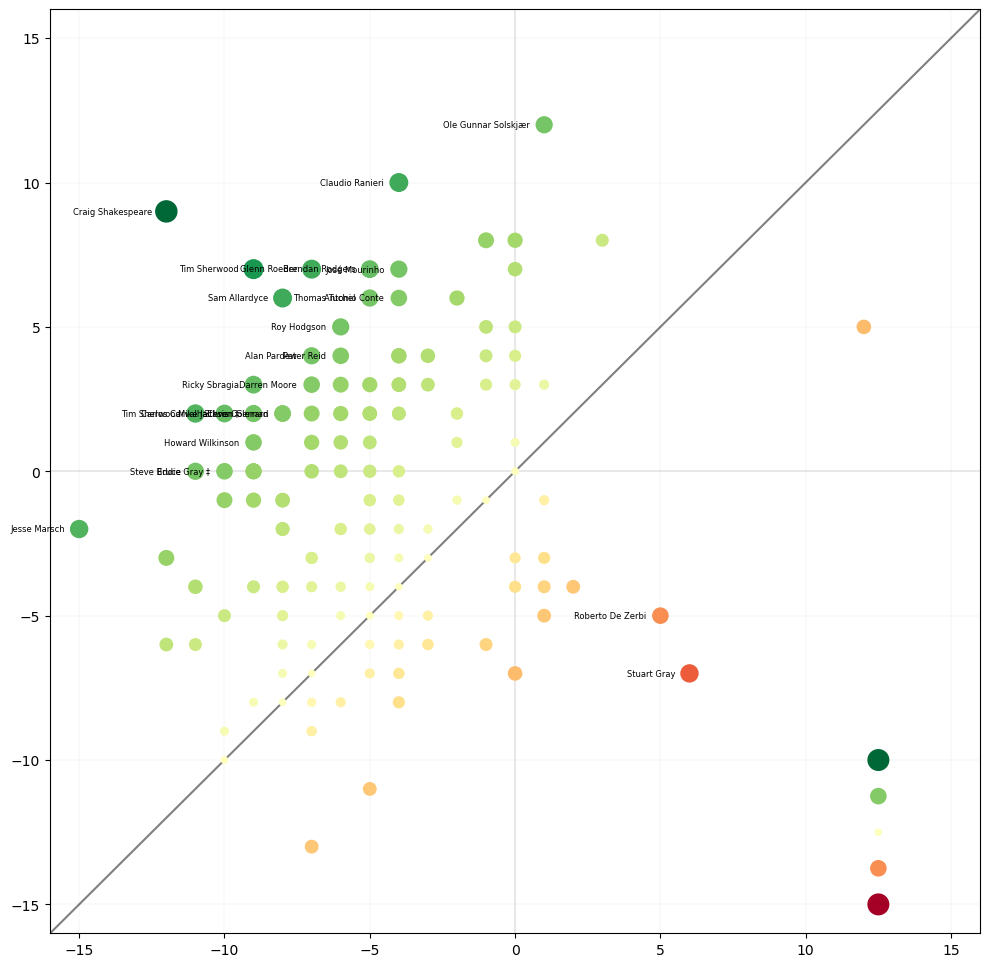

In [656]:
plt.figure(figsize = (12, 12))

plt.plot([-20, 20], [0, 0], c = 'k', linewidth = 0.1)
plt.plot([0, 0], [-20, 20], c = 'k', linewidth = 0.1)
plt.plot([-20, 20], [-20, 20], c = 'k', alpha = 0.5)
plt.scatter(debuts['gd_before'], debuts['gd_after'], c = debuts['gd_imp'], s = 10 * (debuts['gd_imp'].abs() + 2), cmap = 'RdYlGn', zorder = 1000, vmin = -20, vmax = 20)
for name, tm, yr, bef, aft in zip(debuts['Name'], debuts['Team'], debuts['Year'], debuts['gd_before'], debuts['gd_after']) :
    if np.abs(aft - bef) >= 10 :
        txt = f'{name}\n{tm}\n{yr-1}-{str(yr)[-2:]}'
        txt = name
        plt.text(bef - .5, aft, txt, zorder = 1001, va = 'center', ha = 'right', size = 6)
plt.xlim([-16, 16])
plt.ylim([-16, 16])
plt.scatter(5 * [12.5], np.linspace(-10, -15, 5), c = np.linspace(20, -20, 5), vmin = -20, vmax = 20, s = 10 * (np.abs(np.linspace(20, -20, 5)) + 2), cmap = 'RdYlGn')
plt.grid(c = 'k', linewidth = 0.1, alpha = 0.25)
plt.show()

In [636]:
round(debuts['gd_imp'].mean(), 2)

3.92

In [635]:
debuts['gd_imp'].mean()

3.9194630872483223

In [648]:
debuts_sorted = debuts.sort_values('gd_imp', ascending = True).reset_index(drop = True)